In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Conv3D, Conv3DTranspose, BatchNormalization, Dropout, Flatten, Reshape, TimeDistributed
from sklearn.model_selection import train_test_split
import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [ ]:
!nvidia-smi

Wed Jun 23 09:37:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

     |████████████████████████████████| 1.0MB 32.0MB/s 


In [ ]:
import imageio
from tensorflow_docs.vis import embed
import cv2

def to_gif(images):
  
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=25)
  return embed.embed_file('./animation.gif')
  
def generate_movies(n_samples=10,n_frames=21):
    row = 250
    col = 250
    movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float64)
    shifted_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float64)

    for i in range(n_samples):
        n = np.random.randint(3, 8)

        for j in range(n):
            xstart = np.random.randint(100, 140)
            ystart = np.random.randint(100, 140)
            directionx = np.random.randint(0, 3) - 1
            directiony = np.random.randint(0, 3) - 1
            w = np.random.randint(4, 8)

            for t in range(n_frames):
                x_shift = xstart + directionx * t
                y_shift = ystart + directiony * t
                movies[i, t, x_shift - w : x_shift + w, y_shift - w : y_shift + w, 0] += 1

                if np.random.randint(0, 2):
                    noise_f = (-1) ** np.random.randint(0, 2)
                    movies[i,t,x_shift - w - 1 : x_shift + w + 1,y_shift - w - 1 : y_shift + w + 1,0] += (noise_f * 0.1)
                
    movies[movies >= 1] = 1
    return movies


def resize_video(vid):
  res = np.ndarray((vid.shape[0], vid.shape[1], 128, 128, 1))
  for i in range(vid.shape[0]):
    for j in range(vid.shape[1]):
      d = vid[i, j, :, :, :]
      d = cv2.resize(d, dsize=(128, 128))
      d = d.reshape((128, 128, 1))
      res[i, j] = d
  return res


def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y

In [ ]:
data = generate_movies(n_samples=300)
data.shape

(300, 21, 250, 250, 1)


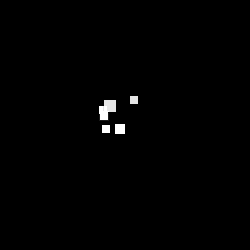

In [ ]:
to_gif(data[100])

Displaying frames for example 95.


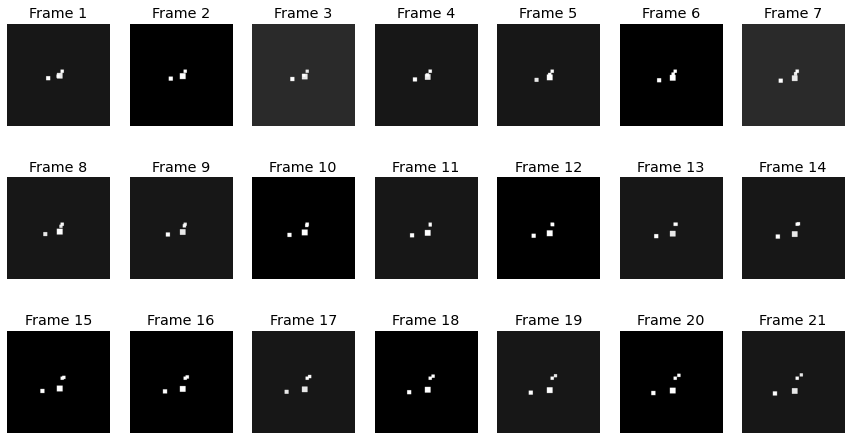

In [ ]:
fig, axes = plt.subplots(3, 7, figsize=(15, 8))

data_choice = np.random.choice(range(len(data)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(data[data_choice][idx][:, : ,0], cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

print(f"Displaying frames for example {data_choice}.")
plt.show()

In [ ]:
x_train, y_train = create_shifted_frames(data)
x_train.shape, y_train.shape

((300, 20, 250, 250, 1), (300, 20, 250, 250, 1))

In [ ]:
idx = np.random.randint(0, len(x_train), int(0.1*len(x_train)))
r_idx = [i for i in range(len(x_train)) if i not in idx]
x_test = x_train[idx]
y_test = y_train[idx]
x_train, y_train = x_train[r_idx], y_train[r_idx]

In [ ]:
del data

In [ ]:
def createModel(rnn=layers.LSTM, name=''):
  model = keras.models.Sequential(name=name)
  model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', strides=(2, 2), activation='relu', name='cnn1'), name='layer1'))
  model.add(TimeDistributed(Conv2D(1, (3, 3), strides=(2, 2), activation='relu', name='cnn2'), name='layer2'))
  model.add(TimeDistributed(Flatten(), name='flatten'))
  model.add(rnn(961, return_sequences=True, name='recurrent'))
  model.add(TimeDistributed(Reshape([31, 31, 1]), name='reshape'))
  model.add(TimeDistributed(Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu', name='cnn6'), name='layer6'))
  model.add(TimeDistributed(Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu', name='cnn7'), name='layer7'))
  model.add(Conv3DTranspose(1, (1, 3, 3), padding='same', strides=(1, 2, 2), activation='relu', name='output'))
  model.build((None, None, *x_train.shape[2:]))

  model.compile(
      loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.RMSprop(),
  )
  return model

## Predict 8th frame
def pred_8th_frame(model, data):
  example = data
  frames = example[:7, ...]
  original_frame = example[8, ...]
  new_prediction = model.predict(np.expand_dims(frames, axis=0))
  new_prediction = np.squeeze(new_prediction, axis=0)
  predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
  plt.figure(figsize=(20, 8))
  plt.subplot(1, 3, 1)
  plt.imshow(np.squeeze(predicted_frame), cmap="gray")
  plt.title(f"Prediction")
  plt.axis("off")
  plt.subplot(1, 3, 2)
  plt.imshow(np.squeeze(original_frame), cmap="gray")
  plt.title(f"Ground Truth")
  plt.axis("off")
  diff = original_frame - predicted_frame
  diff[diff > 0.9] = 1.0
  diff[diff < 0.1] = 0.0
  plt.subplot(1, 3, 3)
  plt.imshow(np.squeeze(diff), cmap="gray")
  plt.title(f"Difference")
  plt.axis("off")
  plt.show()

## LSTM

In [ ]:
lstm_model = createModel(layers.LSTM, name='LSTM')
lstm_model.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (TimeDistributed)     (None, None, 125, 125, 32 320       
_________________________________________________________________
layer2 (TimeDistributed)     (None, None, 62, 62, 1)   289       
_________________________________________________________________
flatten (TimeDistributed)    (None, None, 3844)        0         
_________________________________________________________________
recurrent (LSTM)             (None, None, 961)         18474264  
_________________________________________________________________
reshape (TimeDistributed)    (None, None, 31, 31, 1)   0         
_________________________________________________________________
layer6 (TimeDistributed)     (None, None, 62, 62, 32)  320       
_________________________________________________________________
layer7 (TimeDistributed)     (None, None, 125, 125, 32 9248   

In [ ]:
%%time 

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)


epochs = 25
batch_size = 1


history_lstm = lstm_model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/25
243/243 [==============================] - 13s 46ms/step - loss: 0.0056 - val_loss: 0.0038
Epoch 2/25
243/243 [==============================] - 10s 42ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 3/25
243/243 [==============================] - 10s 43ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 4/25
243/243 [==============================] - 10s 42ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 5/25
243/243 [==============================] - 10s 43ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 6/25
243/243 [==============================] - 10s 41ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 7/25
243/243 [==============================] - 10s 41ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 8/25
243/243 [==============================] - 10s 42ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 9/25
243/243 [==============================] - 10s 42ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 10/25
243/243 [==============================] - 10s 42ms/step - loss: 0.001

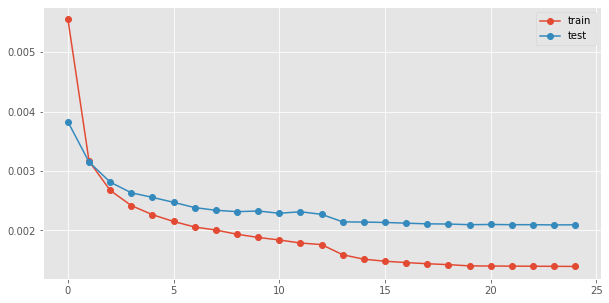

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history_lstm.history['loss'], '-o')
plt.plot(history_lstm.history['val_loss'], '-o')
plt.legend(['train', 'test'])
plt.show()

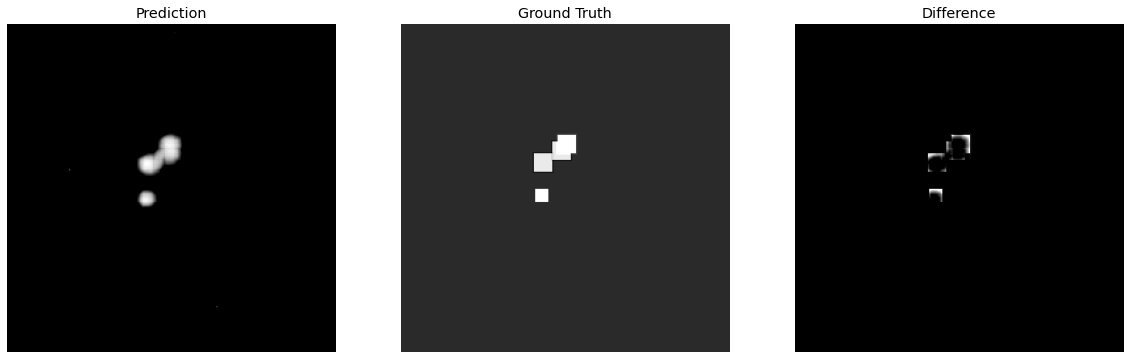

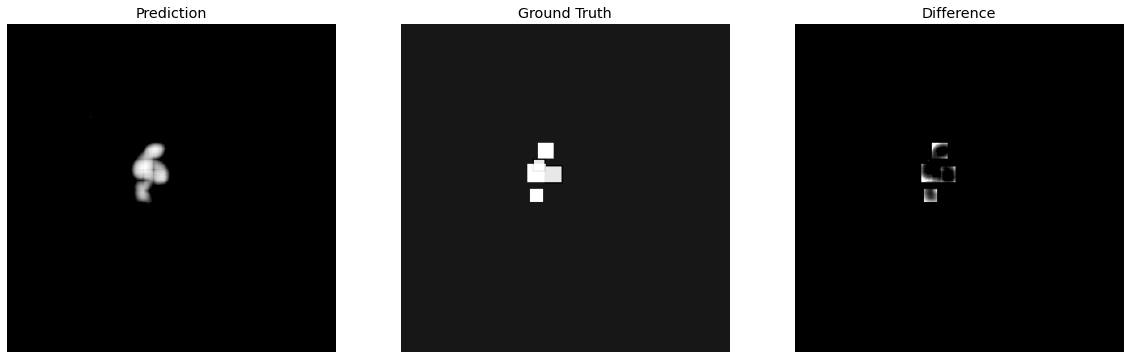

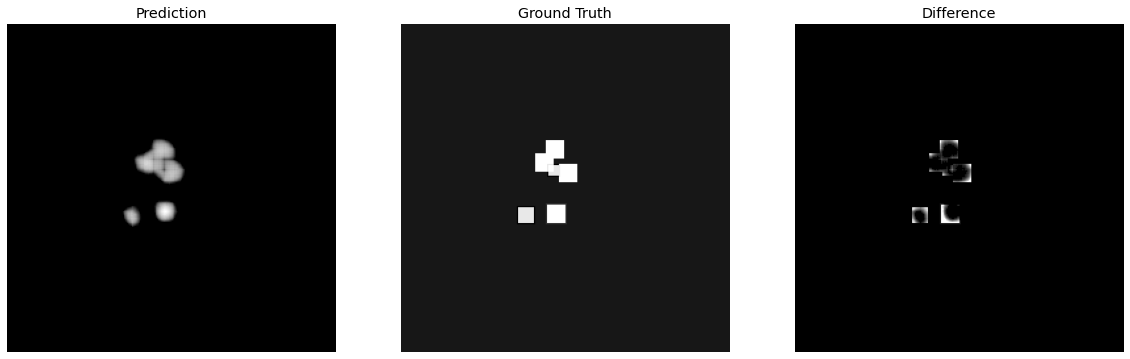

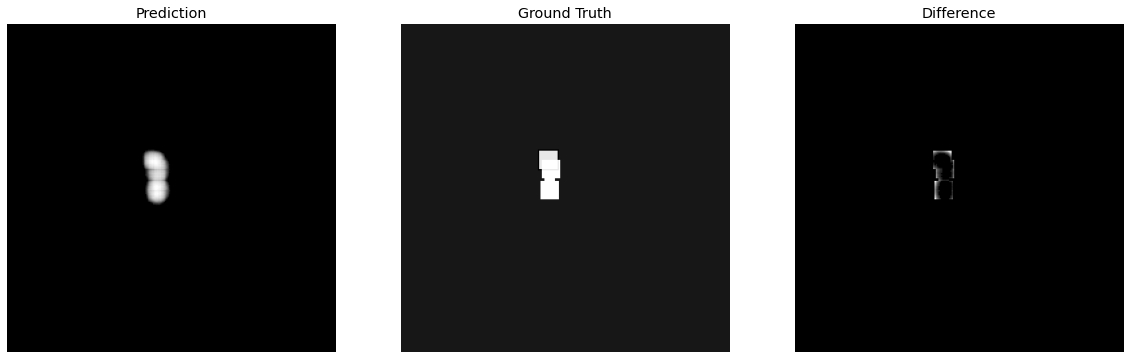

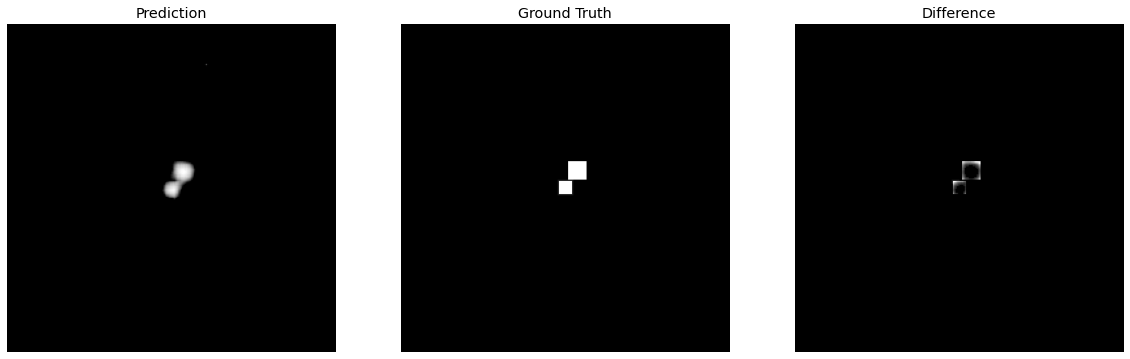

CPU times: user 1.68 s, sys: 68.3 ms, total: 1.74 s
Wall time: 1.74 s


In [ ]:
%%time


pred_8th_frame(lstm_model, x_test[5])
pred_8th_frame(lstm_model, x_test[9])
pred_8th_frame(lstm_model, x_test[4])
pred_8th_frame(lstm_model, x_test[1])
pred_8th_frame(lstm_model, x_test[0])

In [ ]:
lstm_model.save('lstm.h5')

## GRU

In [ ]:
gru_model = createModel(layers.GRU, name='GRU')
gru_model.summary()

Model: "GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (TimeDistributed)     (None, None, 125, 125, 32 320       
_________________________________________________________________
layer2 (TimeDistributed)     (None, None, 62, 62, 1)   289       
_________________________________________________________________
flatten (TimeDistributed)    (None, None, 3844)        0         
_________________________________________________________________
recurrent (GRU)              (None, None, 961)         13858581  
_________________________________________________________________
reshape (TimeDistributed)    (None, None, 31, 31, 1)   0         
_________________________________________________________________
layer6 (TimeDistributed)     (None, None, 62, 62, 32)  320       
_________________________________________________________________
layer7 (TimeDistributed)     (None, None, 125, 125, 32 9248    

In [ ]:
%%time 

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 25
batch_size = 1

# Fit the model to the training data.
history_gru = gru_model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/25
243/243 [==============================] - 44s 41ms/step - loss: 0.0058 - val_loss: 0.0040
Epoch 2/25
243/243 [==============================] - 9s 38ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 3/25
243/243 [==============================] - 9s 37ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 4/25
243/243 [==============================] - 9s 37ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 5/25
243/243 [==============================] - 9s 38ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 6/25
243/243 [==============================] - 9s 38ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 7/25
243/243 [==============================] - 9s 37ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 8/25
243/243 [==============================] - 9s 38ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 9/25
243/243 [==============================] - 9s 37ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 10/25
243/243 [==============================] - 9s 38ms/step - loss: 0.0020 - val_l

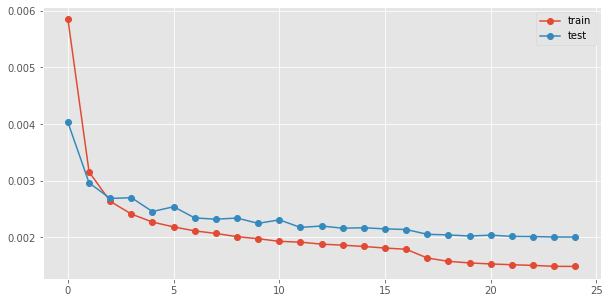

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history_gru.history['loss'], '-o')
plt.plot(history_gru.history['val_loss'], '-o')
plt.legend(['train', 'test'])
plt.show()

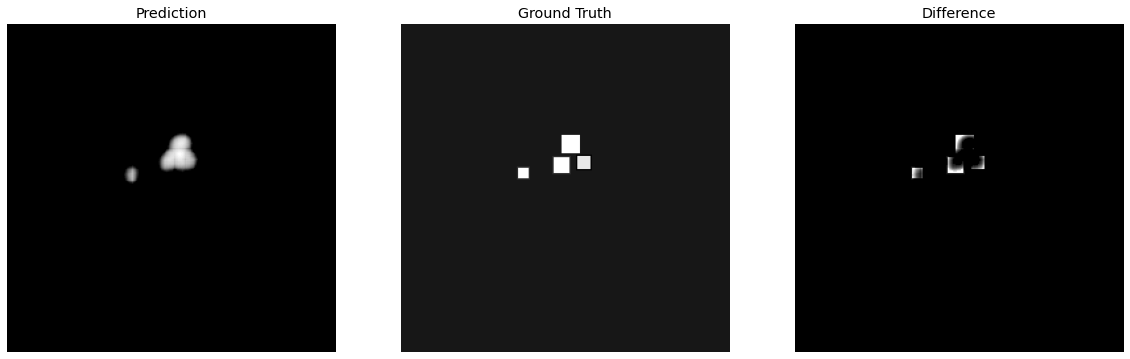

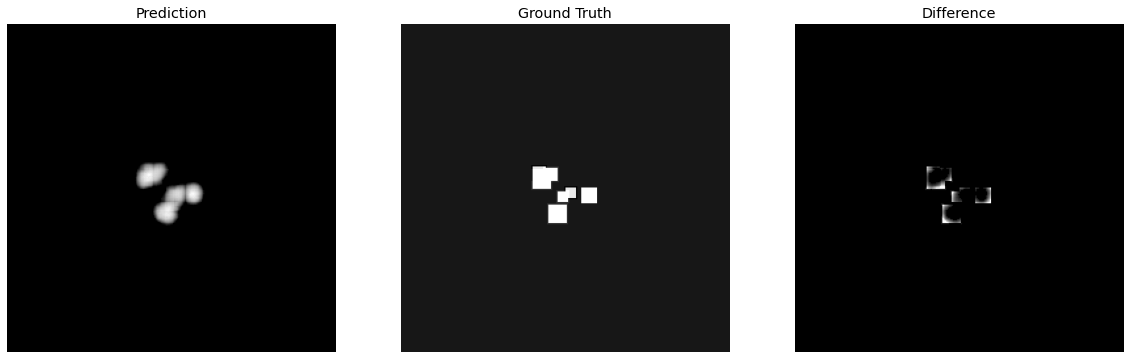

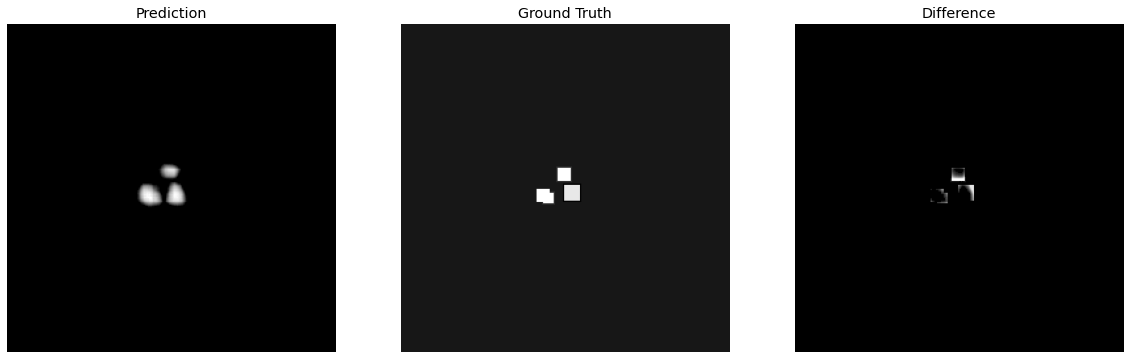

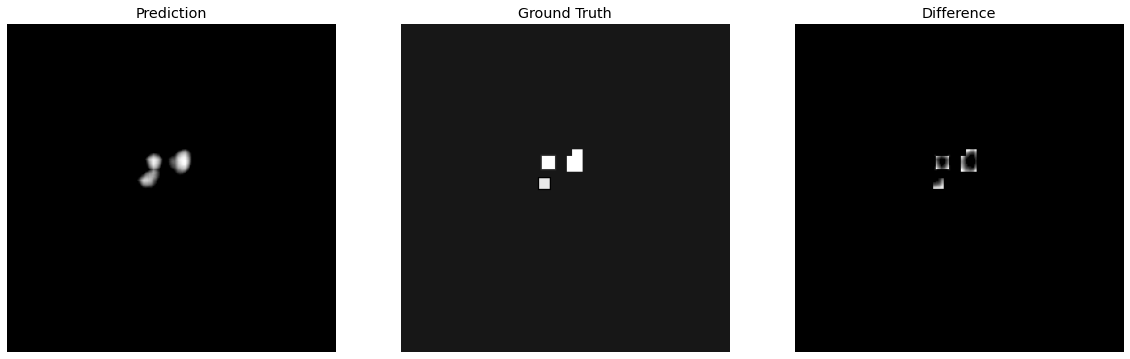

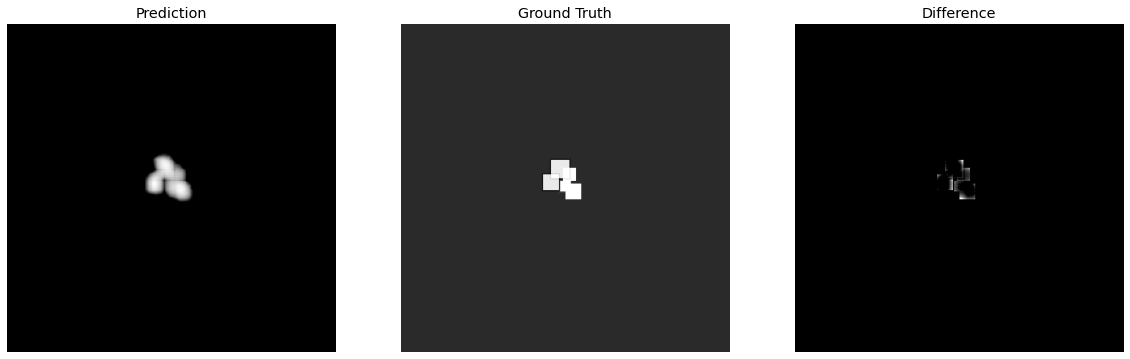

CPU times: user 1.82 s, sys: 99.6 ms, total: 1.92 s
Wall time: 2.08 s


In [ ]:
%%time

pred_8th_frame(gru_model, x_test[5])
pred_8th_frame(gru_model, x_test[9])
pred_8th_frame(gru_model, x_test[4])
pred_8th_frame(gru_model, x_test[1])
pred_8th_frame(gru_model, x_test[0])

In [ ]:
gru_model.save_weights('gru.h5')

## RNN

In [ ]:
rnn_model = createModel(layers.SimpleRNN)
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (TimeDistributed)     (None, None, 125, 125, 32 320       
_________________________________________________________________
layer2 (TimeDistributed)     (None, None, 62, 62, 1)   289       
_________________________________________________________________
flatten (TimeDistributed)    (None, None, 3844)        0         
_________________________________________________________________
recurrent (SimpleRNN)        (None, None, 961)         4618566   
_________________________________________________________________
reshape (TimeDistributed)    (None, None, 31, 31, 1)   0         
_________________________________________________________________
layer6 (TimeDistributed)     (None, None, 62, 62, 32)  320       
_________________________________________________________________
layer7 (TimeDistributed)     (None, None, 125, 125, 32 9

In [ ]:
%%time 

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 25
batch_size = 1

# Fit the model to the training data.
history_rnn = rnn_model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/25
243/243 [==============================] - 44s 48ms/step - loss: 0.0068 - val_loss: 0.0050
Epoch 2/25
243/243 [==============================] - 11s 45ms/step - loss: 0.0045 - val_loss: 0.0042
Epoch 3/25
243/243 [==============================] - 10s 43ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 4/25
243/243 [==============================] - 11s 43ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 5/25
243/243 [==============================] - 11s 44ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 6/25
243/243 [==============================] - 10s 43ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 7/25
243/243 [==============================] - 11s 44ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 8/25
243/243 [==============================] - 11s 44ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 9/25
243/243 [==============================] - 11s 45ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 10/25
243/243 [==============================] - 11s 43ms/step - loss: 0.002

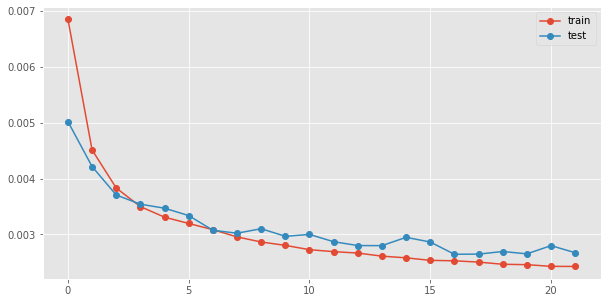

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history_rnn.history['loss'], '-o')
plt.plot(history_rnn.history['val_loss'], '-o')
plt.legend(['train', 'test'])
plt.show()

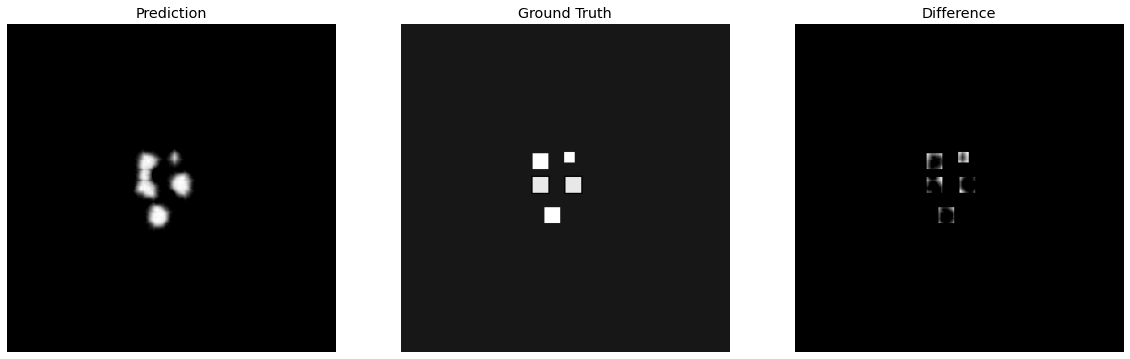

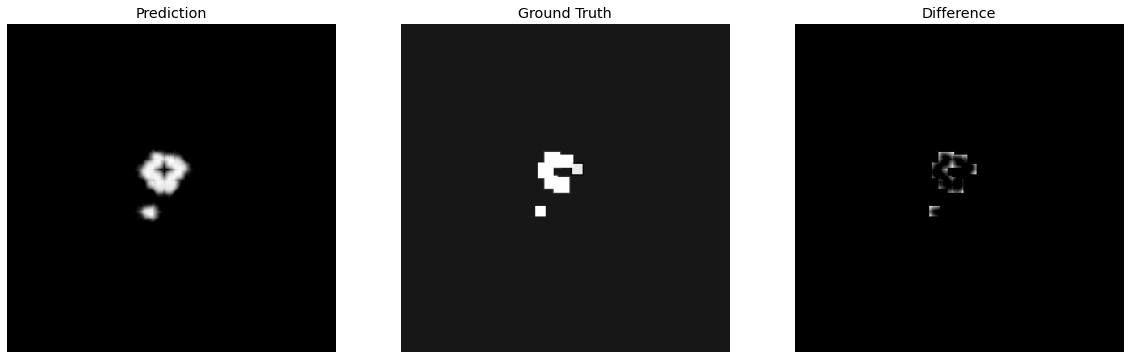

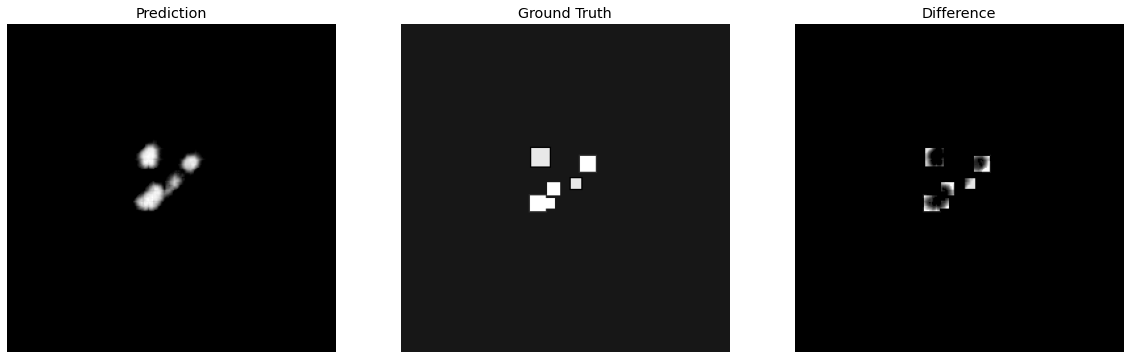

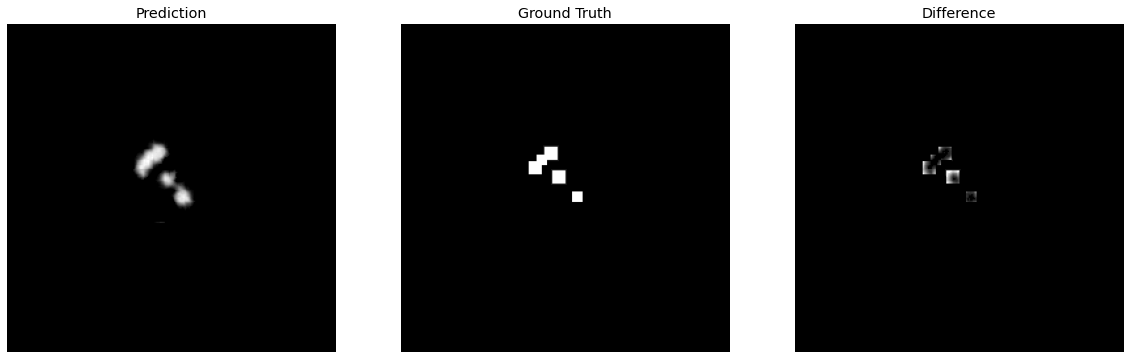

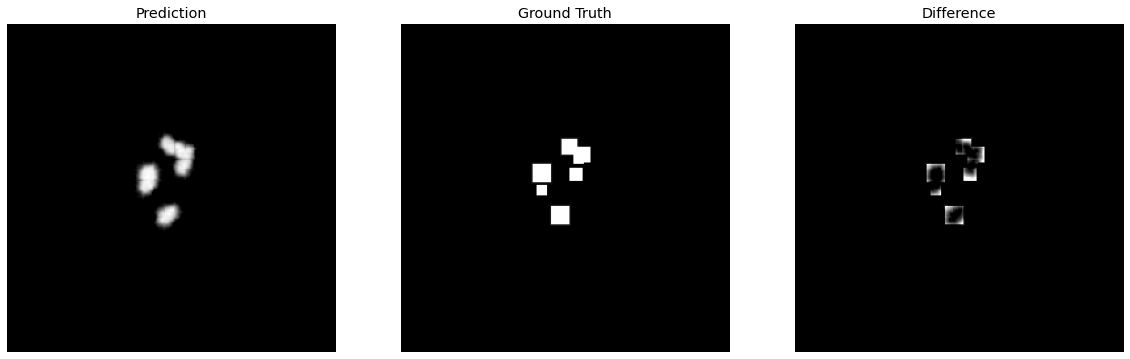

CPU times: user 1.57 s, sys: 109 ms, total: 1.68 s
Wall time: 1.7 s


In [ ]:
%%time

pred_8th_frame(rnn_model, x_test[5])
pred_8th_frame(rnn_model, x_test[9])
pred_8th_frame(rnn_model, x_test[4])
pred_8th_frame(rnn_model, x_test[1])
pred_8th_frame(rnn_model, x_test[0])

In [ ]:
rnn_model.save_weights('rnn.h5')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cp /content/gru.h5 /content/gdrive/My\ Drive/NNDL_Spring1400_Project2
%cp /content/lstm.h5 /content/gdrive/My\ Drive/NNDL_Spring1400_Project2
%cp /content/rnn.h5 /content/gdrive/My\ Drive/NNDL_Spring1400_Project2

## Create Model

In [ ]:
def createModel_final(loss= keras.losses.mean_squared_error, opt= keras.optimizers.RMSprop(), rnn=layers.LSTM, name='LSTM'):
  model = keras.models.Sequential(name=name)
  model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', strides=(2, 2), activation='relu', name='cnn1'), name='layer1'))
  model.add(TimeDistributed(Conv2D(1, (3, 3), strides=(2, 2), activation='relu', name='cnn2'), name='layer2'))
  model.add(TimeDistributed(Flatten(), name='flatten'))
  model.add(rnn(961, return_sequences=True, name='recurrent'))
  model.add(TimeDistributed(Reshape([31, 31, 1]), name='reshape'))
  model.add(TimeDistributed(Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu', name='cnn6'), name='layer6'))
  model.add(TimeDistributed(Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu', name='cnn7'), name='layer7'))
  model.add(Conv3DTranspose(1, (1, 3, 3), padding='same', strides=(1, 2, 2), activation='relu', name='output'))
  model.build((None, None, *x_train.shape[2:]))

  model.compile(
      loss=loss, optimizer=opt,
  )
  return model

## Loss Functions

### Binary Cross Entropy

In [ ]:
bc_model = createModel_final(keras.losses.binary_crossentropy)
bc_model.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (TimeDistributed)     (None, None, 125, 125, 32 320       
_________________________________________________________________
layer2 (TimeDistributed)     (None, None, 62, 62, 1)   289       
_________________________________________________________________
flatten (TimeDistributed)    (None, None, 3844)        0         
_________________________________________________________________
recurrent (LSTM)             (None, None, 961)         18474264  
_________________________________________________________________
reshape (TimeDistributed)    (None, None, 31, 31, 1)   0         
_________________________________________________________________
layer6 (TimeDistributed)     (None, None, 62, 62, 32)  320       
_________________________________________________________________
layer7 (TimeDistributed)     (None, None, 125, 125, 32 9248   

In [ ]:
%%time 

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

epochs = 25
batch_size = 1

history_bc = bc_model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/25
244/244 [==============================] - 46s 46ms/step - loss: 0.0260 - val_loss: 0.0180
Epoch 2/25
244/244 [==============================] - 11s 43ms/step - loss: 0.0137 - val_loss: 0.0142
Epoch 3/25
244/244 [==============================] - 10s 43ms/step - loss: 0.0114 - val_loss: 0.0126
Epoch 4/25
244/244 [==============================] - 10s 43ms/step - loss: 0.0100 - val_loss: 0.0113
Epoch 5/25
244/244 [==============================] - 11s 44ms/step - loss: 0.0095 - val_loss: 0.0107
Epoch 6/25
244/244 [==============================] - 10s 43ms/step - loss: 0.0089 - val_loss: 0.0109
Epoch 7/25
244/244 [==============================] - 11s 44ms/step - loss: 0.0087 - val_loss: 0.0108
Epoch 8/25
244/244 [==============================] - 11s 43ms/step - loss: 0.0087 - val_loss: 0.0102
Epoch 9/25
244/244 [==============================] - 11s 43ms/step - loss: 0.0085 - val_loss: 0.0106
Epoch 10/25
244/244 [==============================] - 10s 43ms/step - loss: 0.008

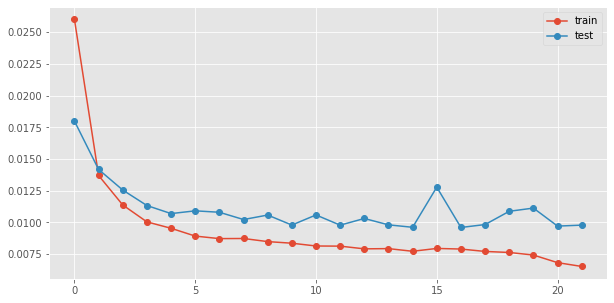

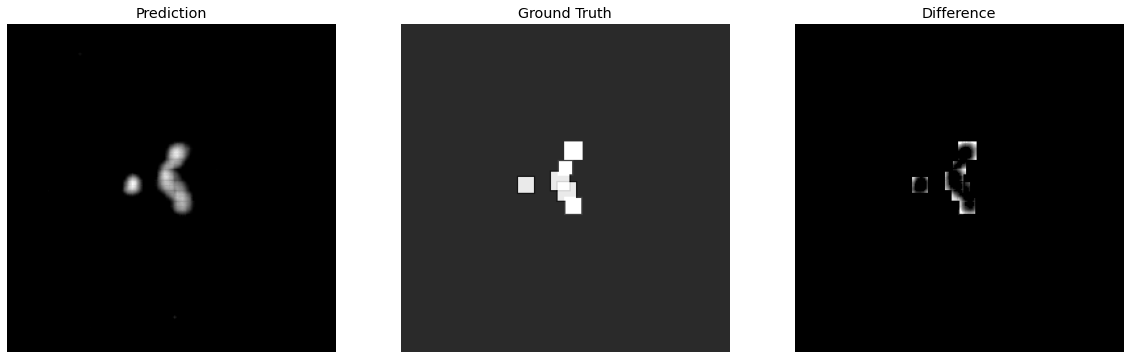

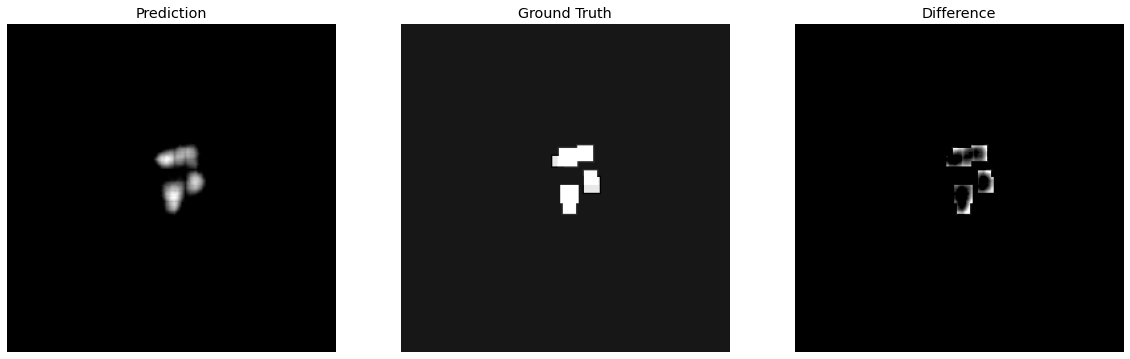

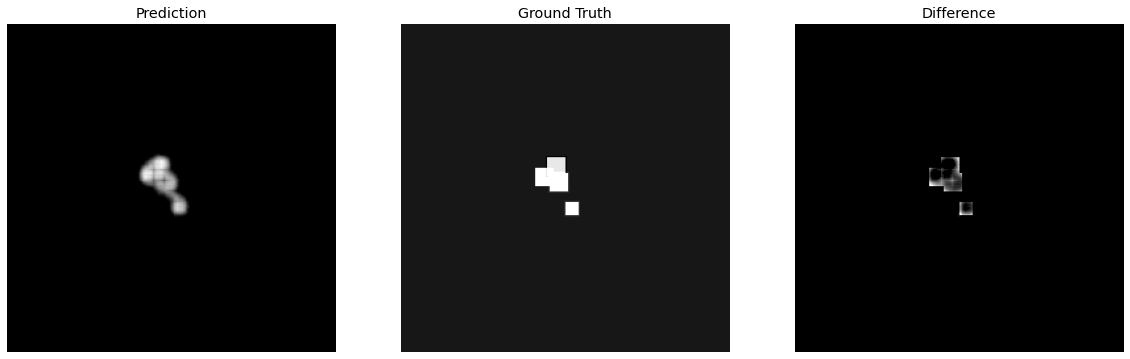

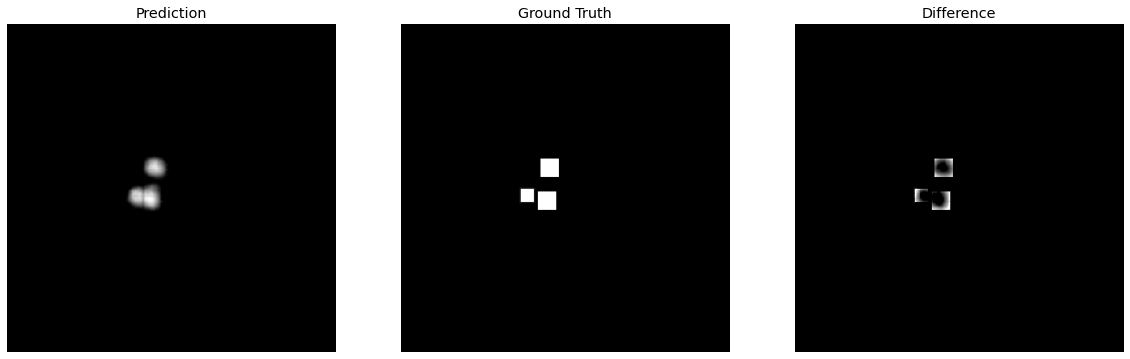

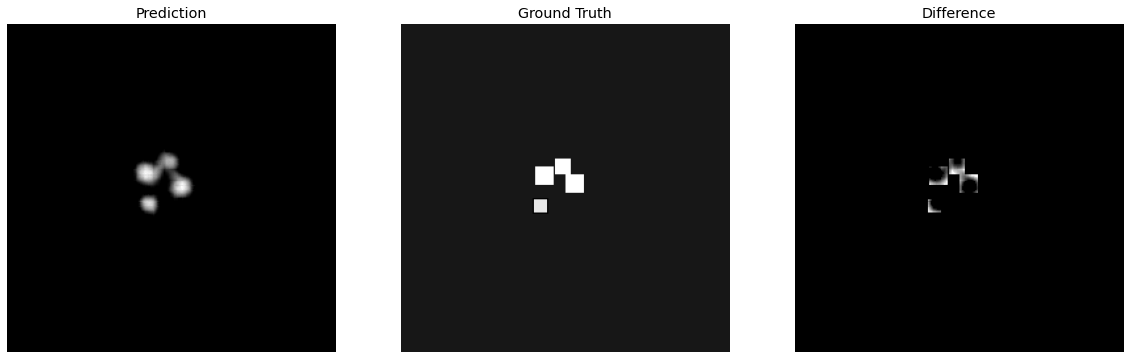

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history_bc.history['loss'], '-o')
plt.plot(history_bc.history['val_loss'], '-o')
plt.legend(['train', 'test'])
plt.show()

pred_8th_frame(bc_model, x_test[5])
pred_8th_frame(bc_model, x_test[9])
pred_8th_frame(bc_model, x_test[4])
pred_8th_frame(bc_model, x_test[1])
pred_8th_frame(bc_model, x_test[0])

### MSE

Epoch 1/25
244/244 [==============================] - 45s 46ms/step - loss: 0.0075 - val_loss: 0.0070
Epoch 2/25
244/244 [==============================] - 10s 42ms/step - loss: 0.0069 - val_loss: 0.0050
Epoch 3/25
244/244 [==============================] - 11s 43ms/step - loss: 0.0044 - val_loss: 0.0038
Epoch 4/25
244/244 [==============================] - 11s 43ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 5/25
244/244 [==============================] - 10s 42ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 6/25
244/244 [==============================] - 10s 43ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 7/25
244/244 [==============================] - 10s 43ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 8/25
244/244 [==============================] - 10s 42ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 9/25
244/244 [==============================] - 10s 42ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 10/25
244/244 [==============================] - 10s 43ms/step - loss: 0.002

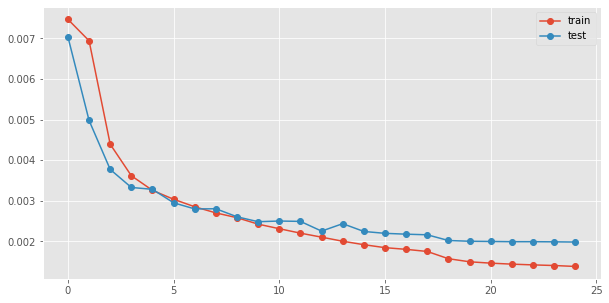

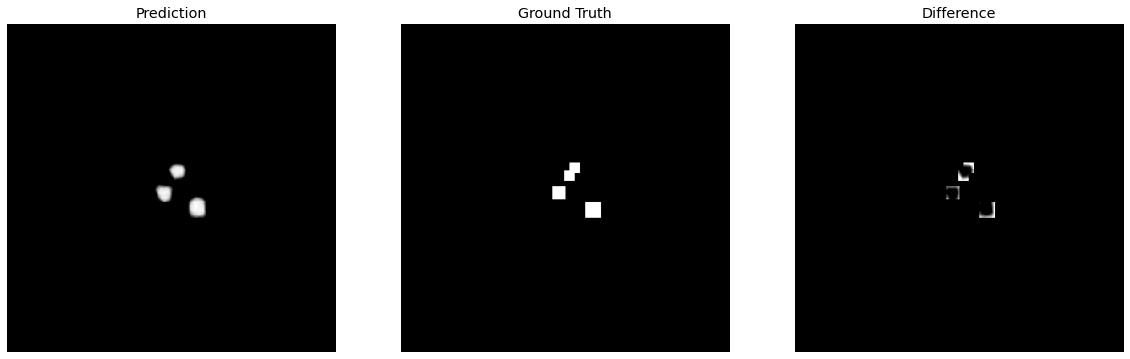

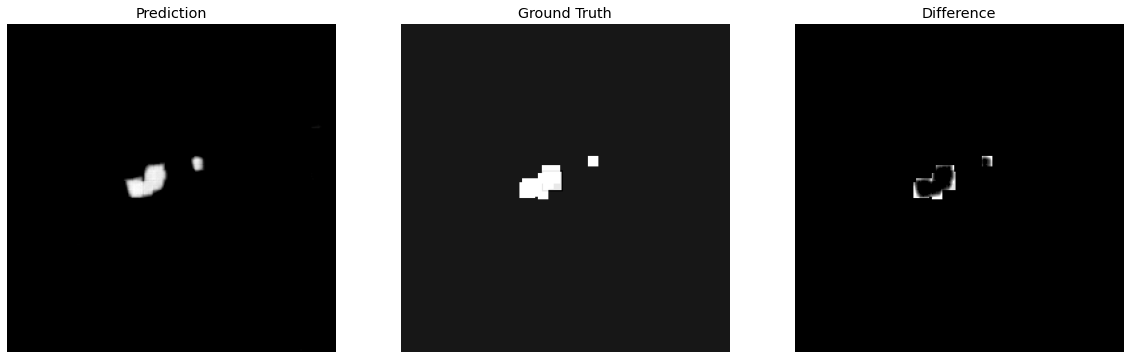

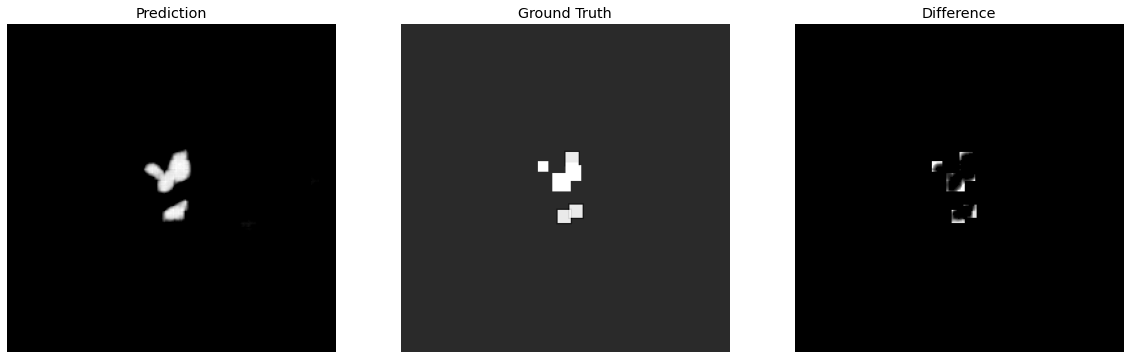

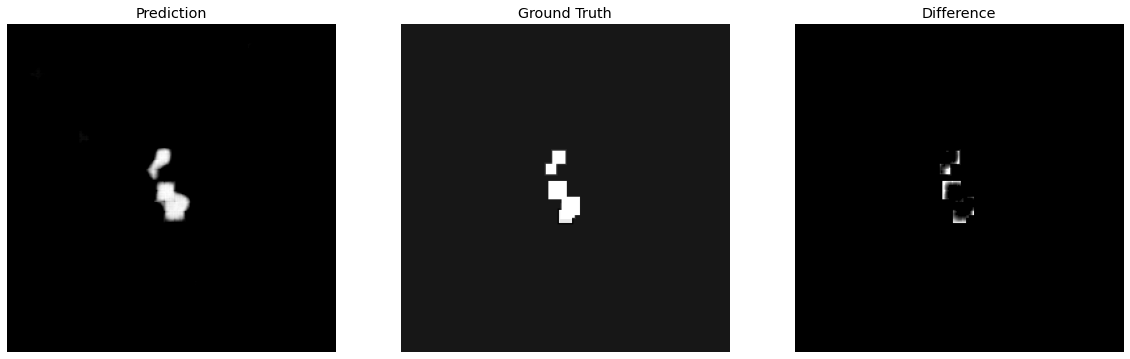

NameError: ignored

In [ ]:
mse_model = createModel_final(keras.losses.mean_squared_error)

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

epochs = 25
batch_size = 1

history_mse = mse_model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr],
)

plt.figure(figsize=(10, 5))
plt.plot(history_mse.history['loss'], '-o')
plt.plot(history_mse.history['val_loss'], '-o')
plt.legend(['train', 'test'])
plt.show()

pred_8th_frame(mse_model, x_test[5])
pred_8th_frame(mse_model, x_test[9])
pred_8th_frame(mse_model, x_test[4])
pred_8th_frame(mse_model, x_test[1])
pred_8th_frame(mse_model, x_test[0])

## Optimizer

### RMSProp

Epoch 1/25
243/243 [==============================] - 45s 46ms/step - loss: 0.0056 - val_loss: 0.0039
Epoch 2/25
243/243 [==============================] - 10s 42ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 3/25
243/243 [==============================] - 10s 43ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 4/25
243/243 [==============================] - 10s 42ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 5/25
243/243 [==============================] - 10s 42ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 6/25
243/243 [==============================] - 10s 43ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 7/25
243/243 [==============================] - 11s 43ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 8/25
243/243 [==============================] - 10s 42ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 9/25
243/243 [==============================] - 10s 43ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 10/25
243/243 [==============================] - 10s 42ms/step - loss: 0.001

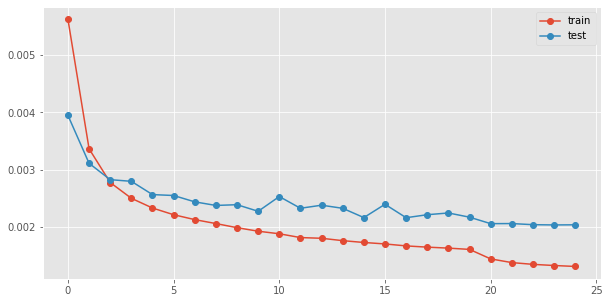

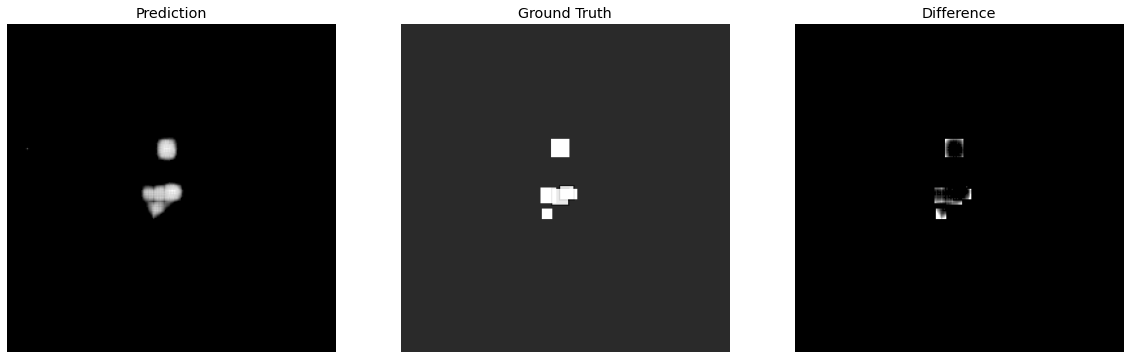

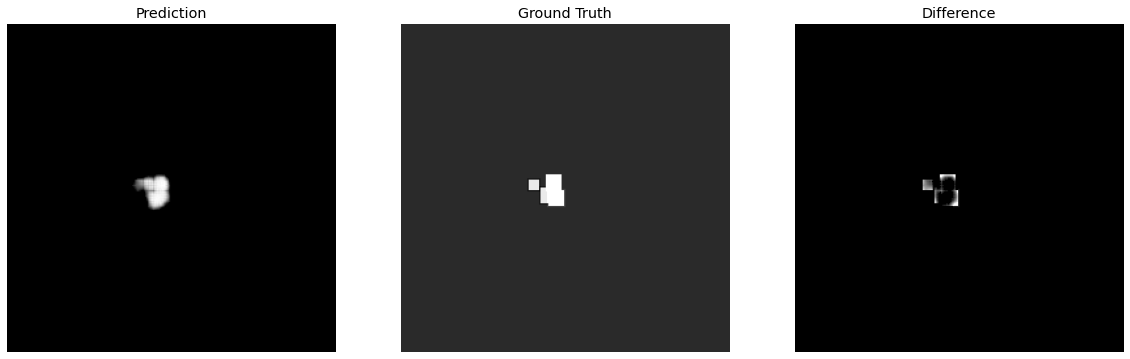

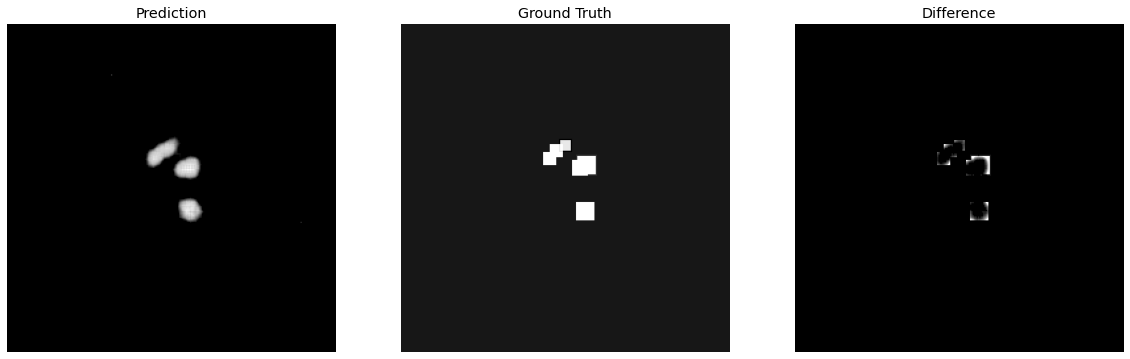

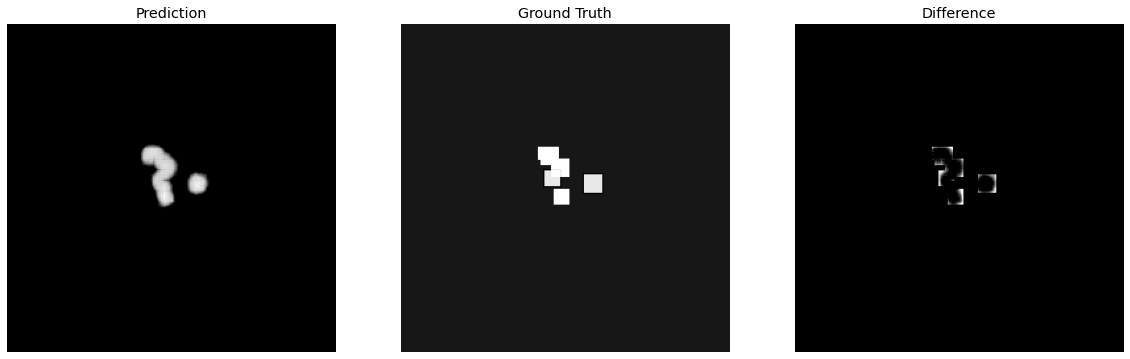

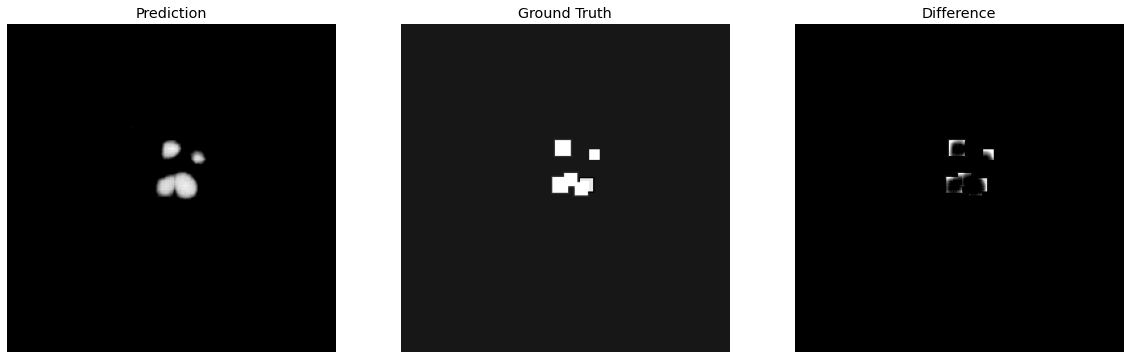

In [ ]:
rmsprop_model = createModel_final(keras.losses.mean_squared_error)

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

epochs = 25
batch_size = 1

history_rmsprop = rmsprop_model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr],
)

plt.figure(figsize=(10, 5))
plt.plot(history_rmsprop.history['loss'], '-o')
plt.plot(history_rmsprop.history['val_loss'], '-o')
plt.legend(['train', 'test'])
plt.show()

pred_8th_frame(rmsprop_model, x_test[5])
pred_8th_frame(rmsprop_model, x_test[9])
pred_8th_frame(rmsprop_model, x_test[4])
pred_8th_frame(rmsprop_model, x_test[1])
pred_8th_frame(rmsprop_model, x_test[0])

### ADAM

Epoch 1/25
245/245 [==============================] - 44s 42ms/step - loss: 0.0075 - val_loss: 0.0069
Epoch 2/25
245/245 [==============================] - 9s 38ms/step - loss: 0.0049 - val_loss: 0.0033
Epoch 3/25
245/245 [==============================] - 9s 38ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 4/25
245/245 [==============================] - 9s 38ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 5/25
245/245 [==============================] - 9s 38ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 6/25
245/245 [==============================] - 9s 37ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 7/25
245/245 [==============================] - 9s 38ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 8/25
245/245 [==============================] - 9s 38ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 9/25
245/245 [==============================] - 9s 38ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 10/25
245/245 [==============================] - 9s 38ms/step - loss: 0.0019 - val_l

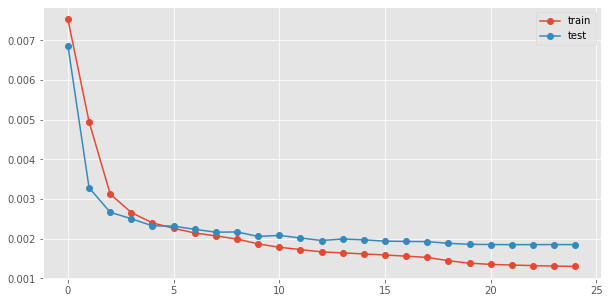

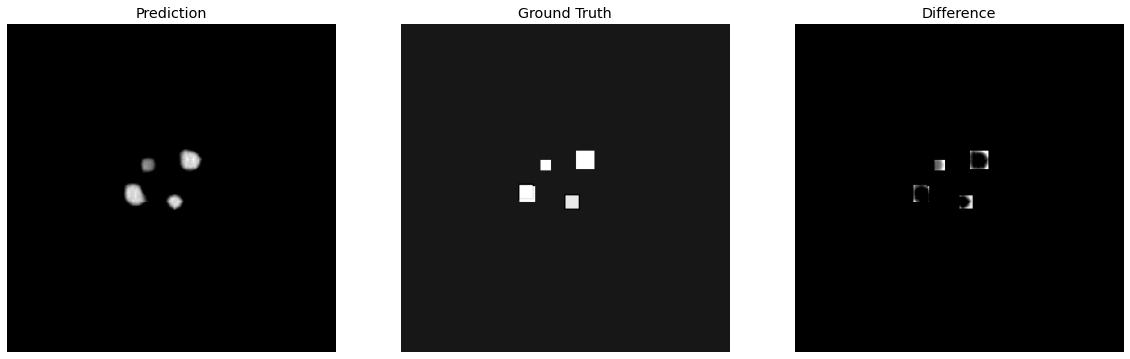

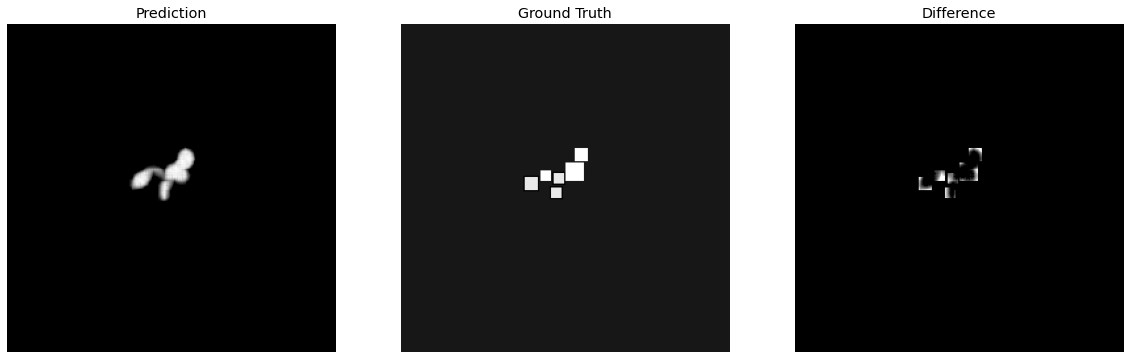

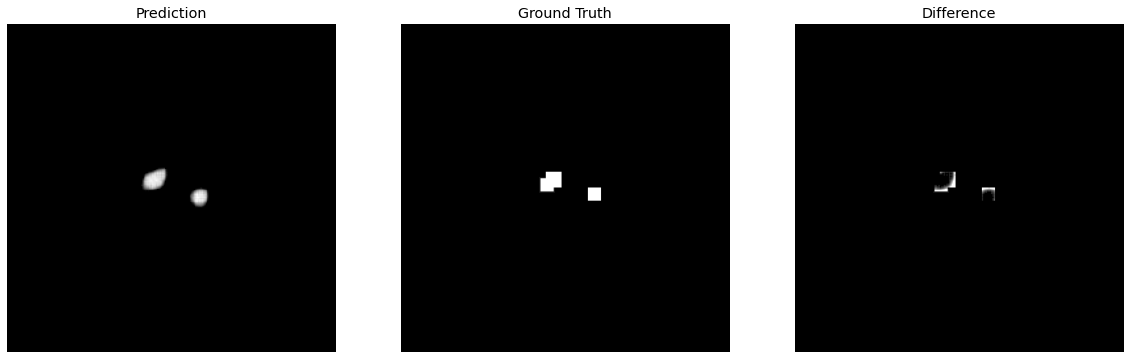

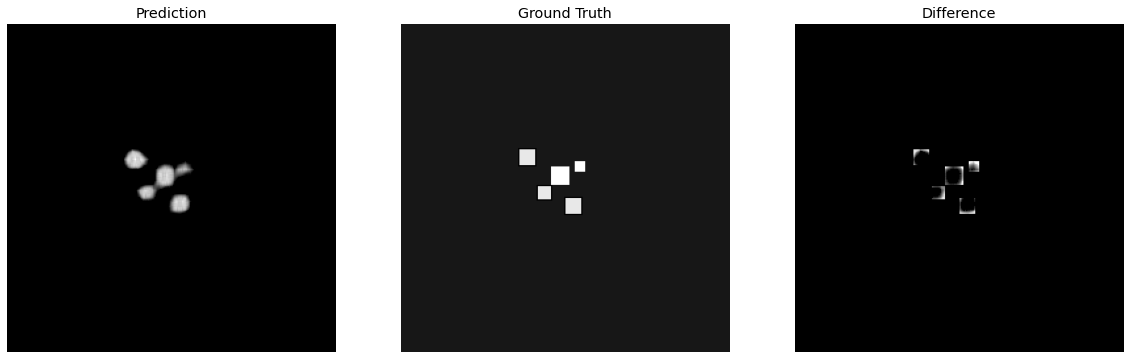

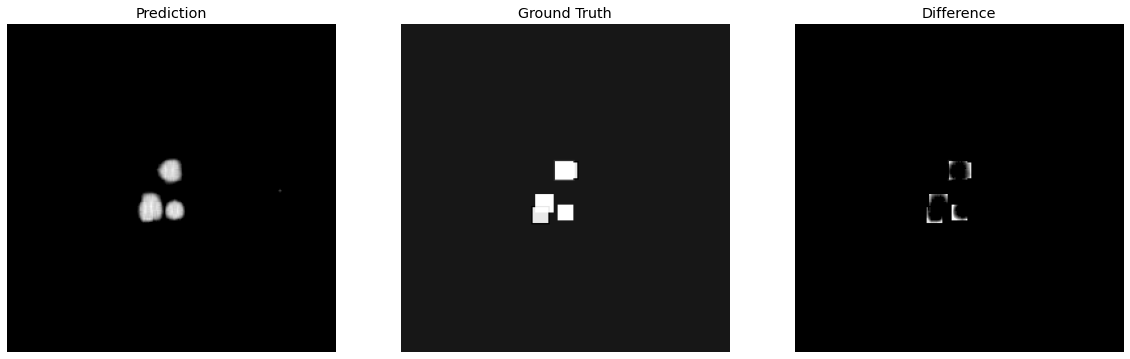

In [ ]:
adam_model = createModel_final(keras.losses.mean_squared_error, opt=keras.optimizers.Adam())

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

epochs = 25
batch_size = 1

history_adam = adam_model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr],
)

plt.figure(figsize=(10, 5))
plt.plot(history_adam.history['loss'], '-o')
plt.plot(history_adam.history['val_loss'], '-o')
plt.legend(['train', 'test'])
plt.show()

pred_8th_frame(adam_model, x_test[5])
pred_8th_frame(adam_model, x_test[9])
pred_8th_frame(adam_model, x_test[4])
pred_8th_frame(adam_model, x_test[1])
pred_8th_frame(adam_model, x_test[0])

## Dropout

In [ ]:
model = keras.models.Sequential(name='LSTM')

model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', strides=(2, 2), name='cnn1'), name='layer1'))
model.add(TimeDistributed(layers.Activation('relu')))
model.add(TimeDistributed(Dropout(0.3)))

# model.add(TimeDistributed(Conv2D(128, (3, 3), strides=(2, 2), name='cnn1'), name='layer2'))
# model.add(TimeDistributed(layers.Activation('relu')))
# model.add(TimeDistributed(Dropout(0.3)))

model.add(TimeDistributed(Conv2D(1, (3, 3), padding='same', strides=(2, 2), name='cnn2'), name='layer3'))
model.add(TimeDistributed(layers.Activation('relu')))
model.add(TimeDistributed(Dropout(0.3)))

model.add(TimeDistributed(Flatten(), name='flatten'))
model.add(layers.LSTM(961, return_sequences=True, name='recurrent'))
model.add(TimeDistributed(Dropout(0.2)))
model.add(TimeDistributed(Reshape([31, 31, 1]), name='reshape'))

model.add(TimeDistributed(Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', name='cnn6'), name='layer6'))
model.add(TimeDistributed(layers.Activation('relu')))
model.add(TimeDistributed(Dropout(0.1)))

model.add(TimeDistributed(Conv2DTranspose(32, (3, 3), strides=(2, 2), name='cnn7'), name='layer7'))
model.add(TimeDistributed(layers.Activation('relu')))
model.add(TimeDistributed(Dropout(0.1)))

model.add(Conv3DTranspose(1, (1, 3, 3), padding='same', strides=(1, 2, 2), activation='relu', name='output'))
model.build((None, None, *x_train.shape[2:]))

model.compile(
    loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(),
)

model.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (TimeDistributed)     (None, None, 125, 125, 32 320       
_________________________________________________________________
time_distributed (TimeDistri (None, None, 125, 125, 32 0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 125, 125, 32 0         
_________________________________________________________________
layer3 (TimeDistributed)     (None, None, 63, 63, 1)   289       
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 63, 63, 1)   0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 63, 63, 1)   0         
_________________________________________________________________
flatten (TimeDistributed)    (None, None, 3969)        0      

In [ ]:
%%time 

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)


epochs = 25
batch_size = 1


history_dropout = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/25
243/243 [==============================] - 49s 73ms/step - loss: 0.0072 - val_loss: 0.0049
Epoch 2/25
243/243 [==============================] - 17s 69ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 3/25
243/243 [==============================] - 17s 69ms/step - loss: 0.0041 - val_loss: 0.0035
Epoch 4/25
243/243 [==============================] - 17s 70ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 5/25
243/243 [==============================] - 17s 70ms/step - loss: 0.0039 - val_loss: 0.0032
Epoch 6/25
243/243 [==============================] - 17s 70ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 7/25
243/243 [==============================] - 17s 69ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 8/25
243/243 [==============================] - 17s 68ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 9/25
243/243 [==============================] - 17s 70ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 10/25
243/243 [==============================] - 17s 70ms/step - loss: 0.003

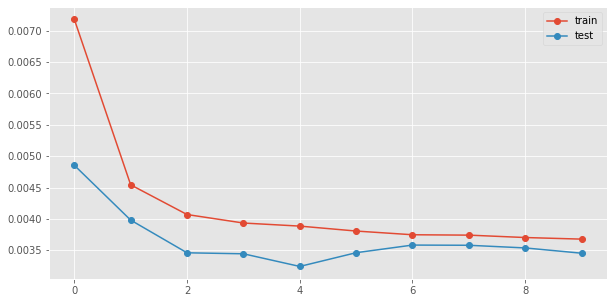

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history_dropout.history['loss'], '-o')
plt.plot(history_dropout.history['val_loss'], '-o')
plt.legend(['train', 'test'])
plt.show()

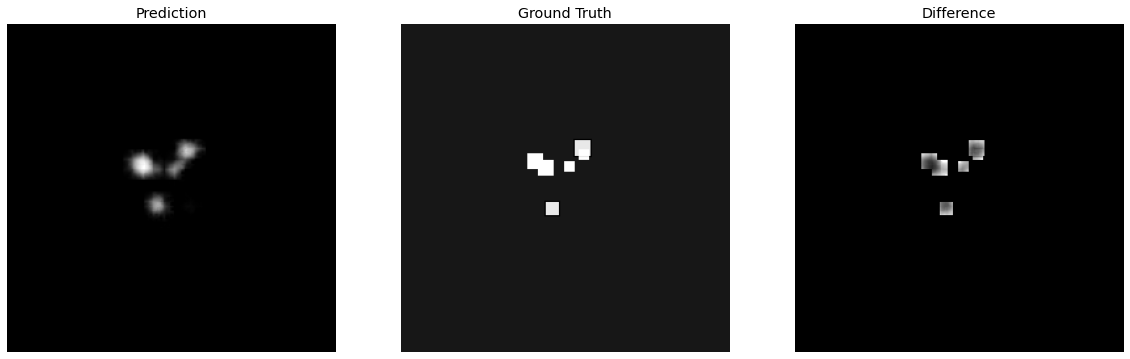

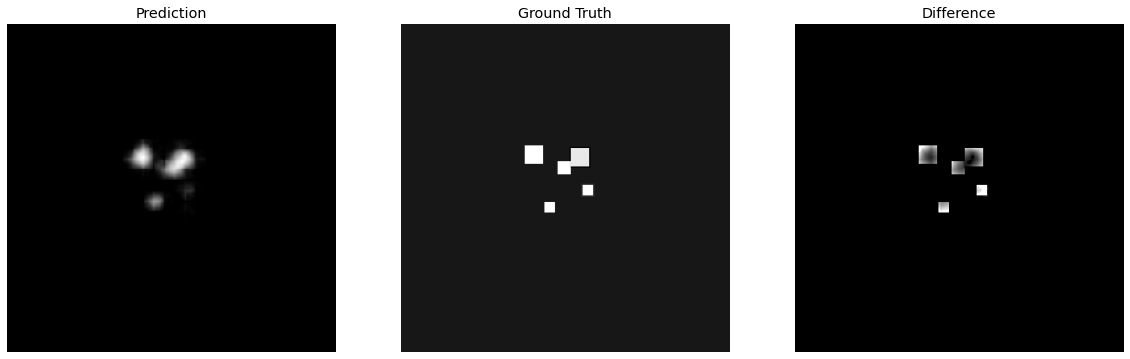

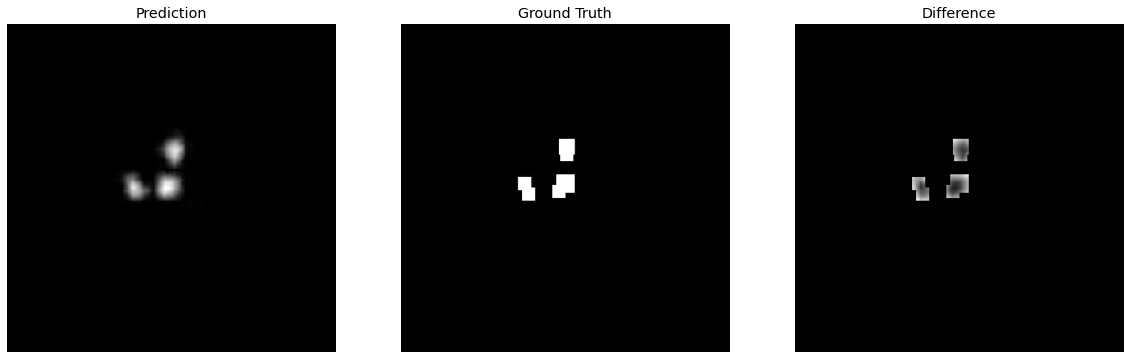

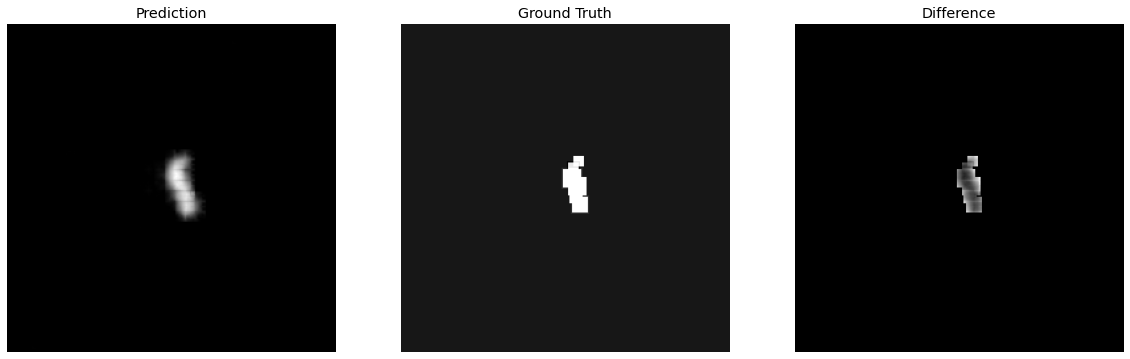

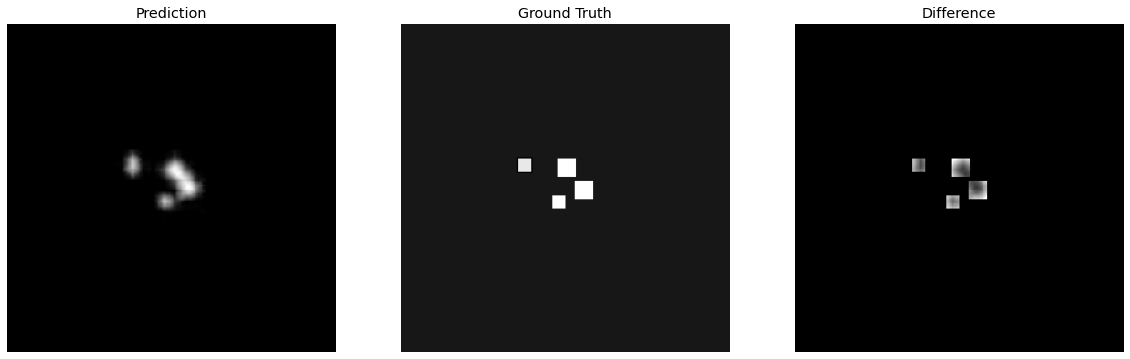

In [ ]:
pred_8th_frame(model, x_test[5])
pred_8th_frame(model, x_test[9])
pred_8th_frame(model, x_test[4])
pred_8th_frame(model, x_test[1])
pred_8th_frame(model, x_test[0])

## More Recurrent Layers

In [ ]:
model = keras.models.Sequential(name='LSTM')

model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', strides=(2, 2), name='cnn1'), name='layer1'))
model.add(TimeDistributed(layers.Activation('relu')))


model.add(TimeDistributed(Conv2D(1, (3, 3), padding='same', strides=(2, 2), name='cnn2'), name='layer3'))
model.add(TimeDistributed(layers.Activation('relu')))

model.add(TimeDistributed(Flatten(), name='flatten'))
model.add(layers.LSTM(961, return_sequences=True, name='recurrent'))
model.add(layers.LSTM(961, return_sequences=True, name='recurrent1'))
model.add(TimeDistributed(Reshape([31, 31, 1]), name='reshape'))

model.add(TimeDistributed(Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', name='cnn6'), name='layer6'))
model.add(TimeDistributed(layers.Activation('relu')))

model.add(TimeDistributed(Conv2DTranspose(32, (3, 3), strides=(2, 2), name='cnn7'), name='layer7'))
model.add(TimeDistributed(layers.Activation('relu')))

model.add(Conv3DTranspose(1, (1, 3, 3), padding='same', strides=(1, 2, 2), activation='relu', name='output'))
model.build((None, None, *x_train.shape[2:]))

model.compile(
    loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(),
)

model.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (TimeDistributed)     (None, None, 125, 125, 32 320       
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 125, 125, 32 0         
_________________________________________________________________
layer3 (TimeDistributed)     (None, None, 63, 63, 1)   289       
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 63, 63, 1)   0         
_________________________________________________________________
flatten (TimeDistributed)    (None, None, 3969)        0         
_________________________________________________________________
recurrent (LSTM)             (None, None, 961)         18954764  
_________________________________________________________________
recurrent1 (LSTM)            (None, None, 961)         7392012

In [ ]:
%%time 

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)


epochs = 25
batch_size = 1


history_backward = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/25
243/243 [==============================] - 47s 51ms/step - loss: 0.0074 - val_loss: 0.0061
Epoch 2/25
243/243 [==============================] - 11s 46ms/step - loss: 0.0045 - val_loss: 0.0043
Epoch 3/25
243/243 [==============================] - 11s 47ms/step - loss: 0.0035 - val_loss: 0.0037
Epoch 4/25
243/243 [==============================] - 11s 47ms/step - loss: 0.0030 - val_loss: 0.0035
Epoch 5/25
243/243 [==============================] - 11s 47ms/step - loss: 0.0027 - val_loss: 0.0033
Epoch 6/25
243/243 [==============================] - 11s 46ms/step - loss: 0.0025 - val_loss: 0.0032
Epoch 7/25
243/243 [==============================] - 11s 46ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 8/25
243/243 [==============================] - 11s 46ms/step - loss: 0.0023 - val_loss: 0.0029
Epoch 9/25
243/243 [==============================] - 11s 47ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 10/25
243/243 [==============================] - 11s 47ms/step - loss: 0.002

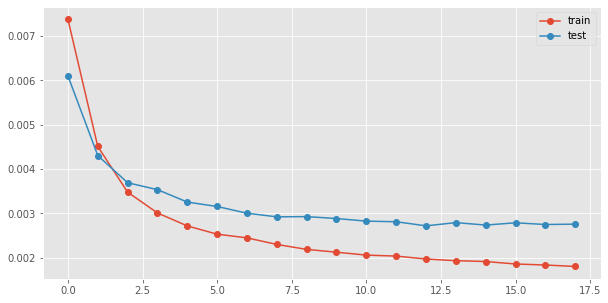

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history_backward.history['loss'], '-o')
plt.plot(history_backward.history['val_loss'], '-o')
plt.legend(['train', 'test'])
plt.show()

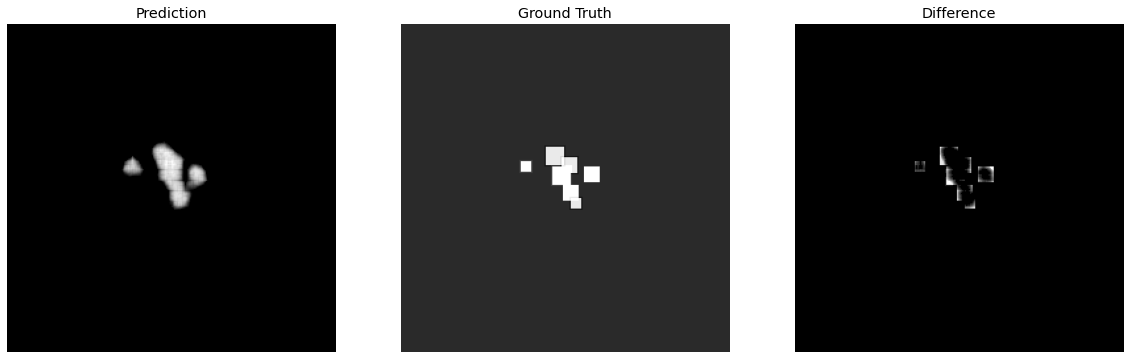

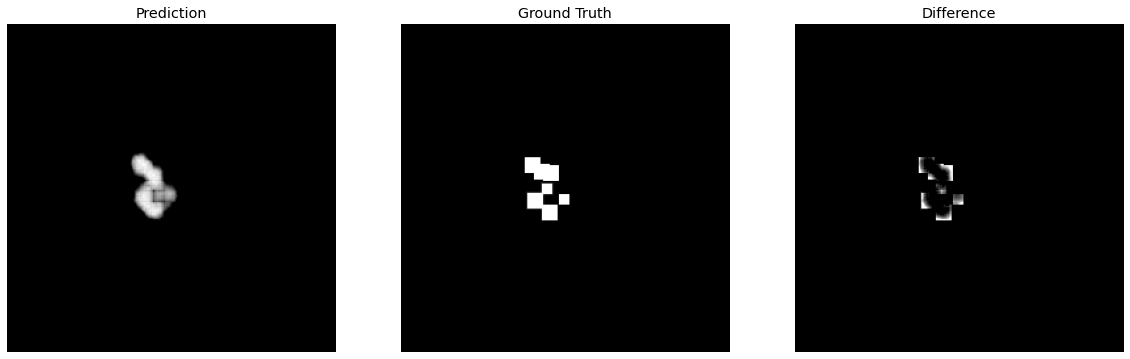

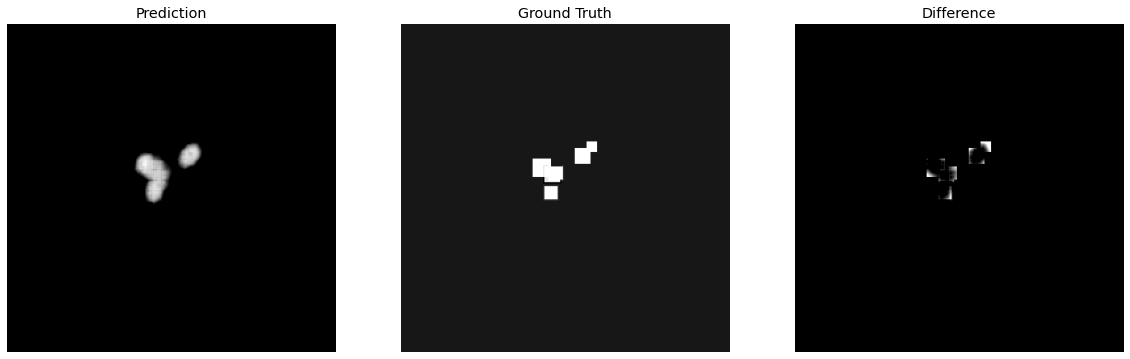

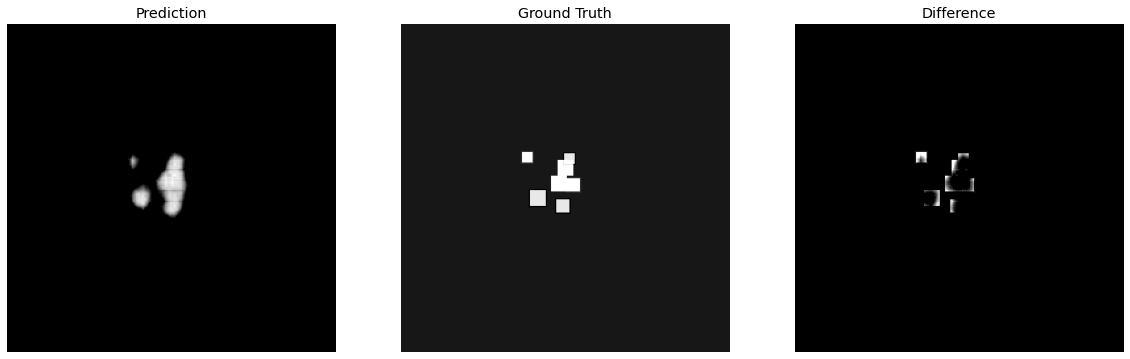

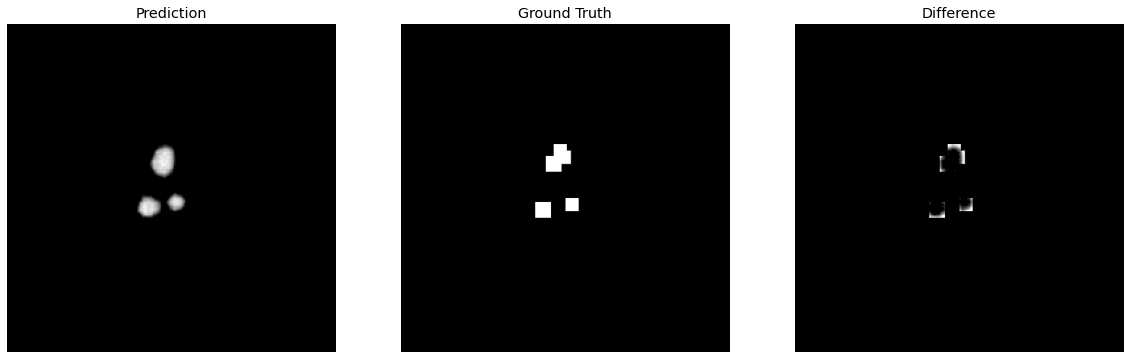

CPU times: user 2.04 s, sys: 146 ms, total: 2.19 s
Wall time: 2.47 s


In [ ]:
%%time 

pred_8th_frame(model, x_test[5])
pred_8th_frame(model, x_test[9])
pred_8th_frame(model, x_test[4])
pred_8th_frame(model, x_test[1])
pred_8th_frame(model, x_test[0])

## Predict

In [ ]:
model = createModel_final(keras.losses.mean_squared_error, opt=keras.optimizers.Adam())

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

epochs = 25
batch_size = 1

model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/25
244/244 [==============================] - 17s 65ms/step - loss: 0.0073 - val_loss: 0.0050
Epoch 2/25
244/244 [==============================] - 15s 63ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 3/25
244/244 [==============================] - 15s 60ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 4/25
244/244 [==============================] - 15s 60ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 5/25
244/244 [==============================] - 15s 60ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 6/25
244/244 [==============================] - 15s 61ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 7/25
244/244 [==============================] - 15s 61ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 8/25
244/244 [==============================] - 15s 60ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 9/25
244/244 [==============================] - 15s 63ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 10/25
244/244 [==============================] - 15s 60ms/step - loss: 0.001

### Predict 3 frames

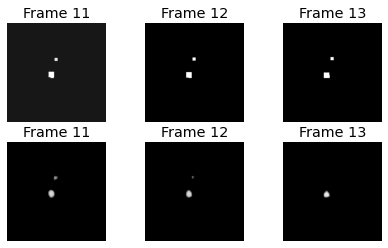

CPU times: user 367 ms, sys: 4.99 ms, total: 372 ms
Wall time: 369 ms


In [ ]:
%%time

example = x_test[5]

frames = example[:10, ...]
original_frames = example[10:, ...]

for _ in range(3):
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    frames = np.concatenate((frames, predicted_frame), axis=0)

fig, axes = plt.subplots(2, 3, figsize=(7, 4))

for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

plt.show()


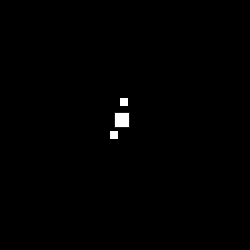

In [ ]:
fs = np.concatenate([frames[:10, :, :, :], new_frames])
fs.shape
to_gif(fs)


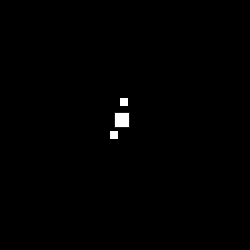

In [ ]:
to_gif(example[:13, :, :, :])

### Predict 10 frames

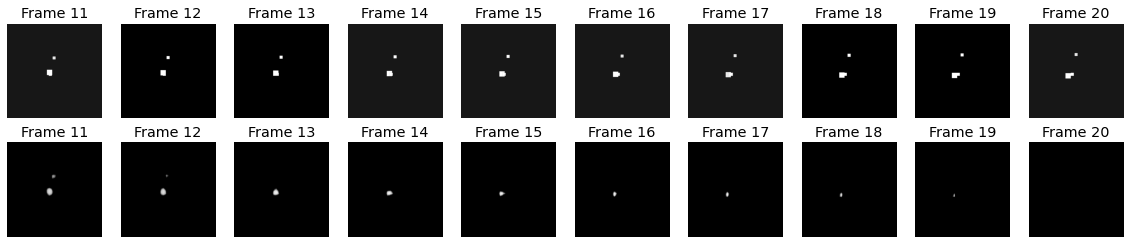

CPU times: user 1.2 s, sys: 23.9 ms, total: 1.23 s
Wall time: 1.3 s


In [ ]:
%%time

example = x_test[5]

frames = example[:10, ...]
original_frames = example[10:, ...]

for _ in range(10):
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    frames = np.concatenate((frames, predicted_frame), axis=0)

fig, axes = plt.subplots(2, 10, figsize=(20, 4))

for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

plt.show()


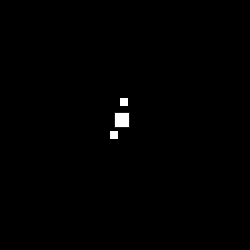

In [ ]:
fs = np.concatenate([frames[:10, :, :, :], new_frames])
fs.shape
to_gif(fs)


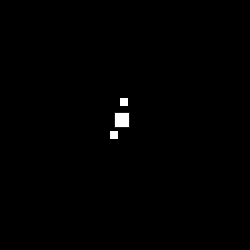

In [ ]:
to_gif(example[:20, :, :, :])